<a href="https://colab.research.google.com/github/Charish53/RL_lab/blob/main/LAB07/CS22B1095_LAB07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 50, Average Reward: 9.42
Episode 100, Average Reward: 9.38
Episode 150, Average Reward: 9.44
Episode 200, Average Reward: 9.46
Episode 250, Average Reward: 9.34
Episode 300, Average Reward: 9.38
Episode 350, Average Reward: 9.40
Episode 400, Average Reward: 9.42
Episode 450, Average Reward: 9.40
Episode 500, Average Reward: 9.46


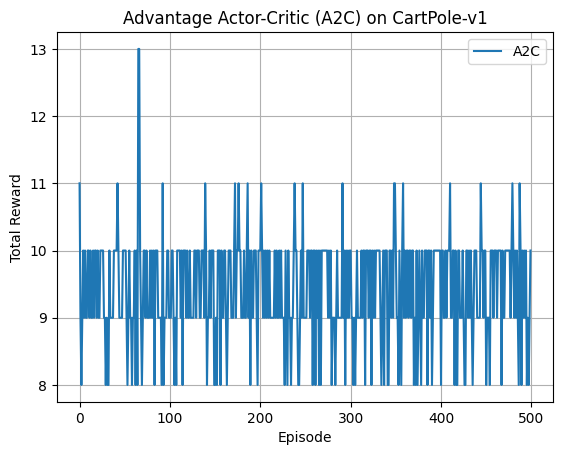

In [4]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
lr = 0.01
gamma = 0.99
num_episodes = 500

# Create Environment
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.fc(state)

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        return self.fc(state)

# Initialize networks and optimizers
actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=lr)
critic_optimizer = optim.Adam(critic.parameters(), lr=lr)

# Advantage estimation using one-step TD-error
def compute_td_error(state, reward, next_state, done):
    state_value = critic(state)
    next_state_value = critic(next_state)
    td_target = reward + (1 - done) * gamma * next_state_value
    td_error = td_target - state_value
    return td_error.detach(), td_target.detach()

# A2C Training Loop
episode_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.from_numpy(state).float()
    done = False
    total_reward = 0

    while not done:
        # Get action probabilities from actor
        probs = actor(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        # Take action in environment
        next_state, reward, done, truncated, _ = env.step(action.item())
        next_state = torch.from_numpy(next_state).float()

        # Compute advantage (TD-error) and target
        td_error, td_target = compute_td_error(state, reward, next_state, float(done))

        # Actor loss (policy gradient with advantage)
        actor_loss = -dist.log_prob(action) * td_error
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # Critic loss (MSE between predicted and TD target)
        critic_loss = (critic(state) - td_target).pow(2)
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Move to next state
        state = next_state
        total_reward += reward

    episode_rewards.append(total_reward)

    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"Episode {episode+1}, Average Reward: {avg_reward:.2f}")

# Plot total reward per episode
plt.plot(episode_rewards, label='A2C')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Advantage Actor-Critic (A2C) on CartPole-v1')
plt.legend()
plt.grid()
plt.show()


REINFORCE Episode 50, Average Reward: 26.76
REINFORCE Episode 100, Average Reward: 65.64
REINFORCE Episode 150, Average Reward: 293.88
REINFORCE Episode 200, Average Reward: 73.70
REINFORCE Episode 250, Average Reward: 104.46
REINFORCE Episode 300, Average Reward: 466.20
REINFORCE Episode 350, Average Reward: 241.80
REINFORCE Episode 400, Average Reward: 240.22
REINFORCE Episode 450, Average Reward: 466.28
REINFORCE Episode 500, Average Reward: 480.88


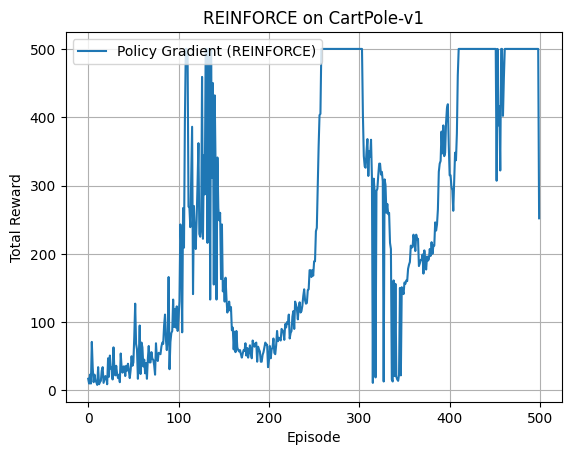

In [13]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
lr = 0.01
gamma = 0.99
num_episodes = 500

# Create Environment
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
max_steps_per_episode = env.spec.max_episode_steps

# Policy Network (for REINFORCE)
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.fc(state)

# Initialize policy and optimizer
policy_pg = PolicyNetwork(state_dim, action_dim)
policy_pg_optimizer = optim.Adam(policy_pg.parameters(), lr=lr)

# Training loop
episode_rewards_pg = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.from_numpy(state).float()
    done = False
    log_probs = []
    rewards = []
    total_reward = 0
    step_count = 0

    while not done and step_count < max_steps_per_episode:
        # Get action probabilities from policy
        probs = policy_pg(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        # Take action in environment
        next_state, reward, done, truncated, _ = env.step(action.item())
        next_state = torch.from_numpy(next_state).float()

        # Save log probability and reward
        log_probs.append(dist.log_prob(action))
        rewards.append(reward)

        state = next_state
        total_reward += reward
        step_count += 1

    # Compute discounted returns
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)  # Normalize

    # Policy loss
    policy_loss = []
    for log_prob, G in zip(log_probs, returns):
        policy_loss.append(-log_prob * G)
    policy_loss = torch.stack(policy_loss).sum()

    policy_pg_optimizer.zero_grad()
    policy_loss.backward()
    policy_pg_optimizer.step()

    # Track total reward
    episode_rewards_pg.append(total_reward)

    # Print average reward every 50 episodes
    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards_pg[-50:])
        print(f"REINFORCE Episode {episode+1}, Average Reward: {avg_reward:.2f}")

# Plot reward curve
plt.plot(episode_rewards_pg, label='Policy Gradient (REINFORCE)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('REINFORCE on CartPole-v1')
plt.legend()
plt.grid()
plt.show()



Final 50-episode average (A2C): 9.34
Final 50-episode average (REINFORCE): 480.88


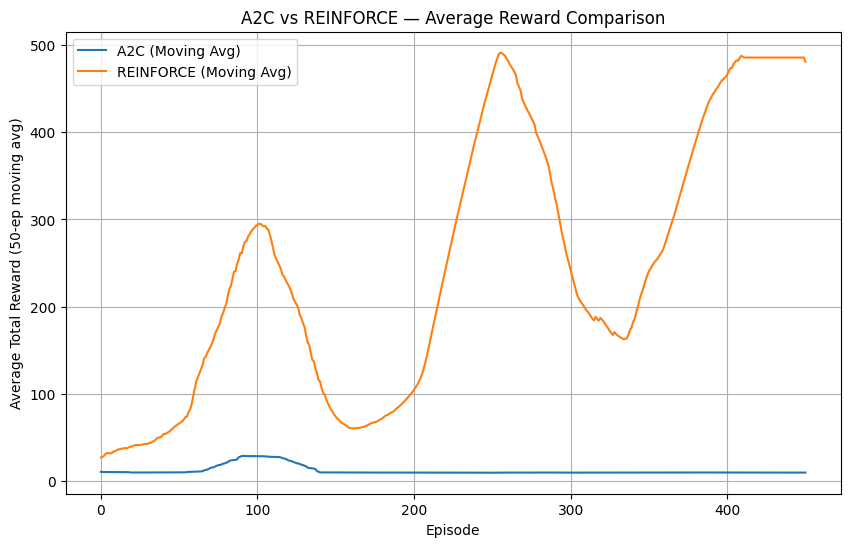

In [14]:
# --- Compute average rewards over last N episodes ---
def moving_average(rewards, window=50):
    return np.convolve(rewards, np.ones(window)/window, mode='valid')

avg_rewards_a2c = moving_average(episode_rewards_a2c)
avg_rewards_pg = moving_average(episode_rewards_pg)

# --- Final average rewards ---
final_avg_a2c = np.mean(episode_rewards_a2c[-50:])
final_avg_pg = np.mean(episode_rewards_pg[-50:])

print(f"\nFinal 50-episode average (A2C): {final_avg_a2c:.2f}")
print(f"Final 50-episode average (REINFORCE): {final_avg_pg:.2f}")

# --- Combined Plot ---
plt.figure(figsize=(10, 6))
plt.plot(avg_rewards_a2c, label='A2C (Moving Avg)')
plt.plot(avg_rewards_pg, label='REINFORCE (Moving Avg)')
plt.xlabel('Episode')
plt.ylabel('Average Total Reward (50-ep moving avg)')
plt.title('A2C vs REINFORCE — Average Reward Comparison')
plt.legend()
plt.grid()
plt.show()
